In [1]:
import warnings
warnings.filterwarnings('ignore')

In [77]:
from googleapiclient.discovery import build 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cinonbak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cinonbak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
api_key = ''

In [4]:
channel_id = ['UC6huXz0F6-7KA7-mW0jdejA']

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

def get_channel_stats (youtube, channel_id):
    
    all_data = []
    

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id= channel_id 
    )
    response = request.execute()

    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalViews': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
               }
        
        all_data.append(data)
    
    return(pd.DataFrame(all_data))

In [6]:
channel_stats = get_channel_stats(youtube, channel_id)

In [22]:
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,ErikTheElectric,2190000,418403985,1119,UU6huXz0F6-7KA7-mW0jdejA


In [15]:
playlist_id = 'UU6huXz0F6-7KA7-mW0jdejA'

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [16]:
video_ids = get_video_ids(youtube, playlist_id)

In [18]:
len(video_ids)

1120

In [23]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [25]:
video_df = get_video_details(youtube, video_ids)

In [26]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,xSq2-FkhpNk,ErikTheElectric,Eating The HIGHEST CALORIE Last Meal Request E...,"In 2012, Gary Carl Simmons made history by req...","[eriktheelectric, erik the electric, erik the ...",2023-03-21T19:39:50Z,625461,25905,None,2102,PT16M15S,hd,false
1,R6Oqwg0t2P4,ErikTheElectric,"Pro Eater Vs. 10,000+ CALORIES of KFC Double D...",KFC recently just re-released their legendary ...,"[erik the electric, erik the electric short, k...",2023-03-15T20:00:59Z,219058,14542,None,199,PT59S,hd,false
2,kR8LLPtJVZA,ErikTheElectric,I Ate Like Matt Stonie For 24 Hours,​@mattstonie is the biggest name in eating ch...,"[erik the electric, erik the electric eating c...",2023-03-04T18:00:16Z,1495623,89508,None,4051,PT18M51S,hd,false
3,U8uLeV0VByk,ErikTheElectric,Pro Eater Vs FOUR Cardi B & Offset McDonald’s ...,I tried eating as many of the new Cardi B & Of...,"[erik the electric, food challenge, eating cha...",2023-02-26T17:50:12Z,177750,10464,None,142,PT1M,hd,false
4,SHVAXf7zVA0,ErikTheElectric,I Ate Only FAMILY SIZED Fast Food Meals For a Day,"For One Day, I attempted to eat ONLY Family Si...","[erik the electric, erik the electric food cha...",2023-02-22T20:00:08Z,2554876,83535,None,7435,PT16M47S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,HfsNzEzFJu4,ErikTheElectric,High Protein White Chocolate Chip Fudge (simpl...,Ingredients:\n- 1 Cup Non fat greek yogurt\n- ...,"[Fudge, Protein Creations, Bodybuilding, Recip...",2013-10-29T02:58:45Z,14050,225,None,23,PT3M17S,sd,false
1116,1mxsabXEogk,ErikTheElectric,"Spaghetti Squash ""Pasta""",Ingredients:\n- Spaghetti Squash\n- Canned/Fre...,"[Spaghetti Squash, Squash, Recipes, Low Carb, ...",2013-10-24T05:16:13Z,18767,320,None,65,PT6M12S,sd,false
1117,dyhOFLusfl8,ErikTheElectric,"Easy 3 Minute ""Protein Cake""",**Like/Subscribe if you enjoyed**\n\n**Macros*...,[Easy Bodybuilding Recipe Protein Cake celluco...,2013-09-20T04:00:44Z,5348,168,None,12,PT3M41S,sd,false
1118,D2S-EZY_Izc,ErikTheElectric,"""Easy"" High Protein Quiche Recipe","Pretty easy/simple recipe, something I enjoy. ...",[Erik the electric high protein recipe quiche ...,2013-09-13T03:17:46Z,7971,249,None,18,PT5M33S,sd,false


# Data Preprocessing

In [27]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [28]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [29]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [41]:
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'])

In [42]:
video_df['publishedDayName'] = video_df['publishedAt'].dt.day_name()

In [60]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')


In [61]:
video_df[['duration','durationSecs']]

,duration,durationSecs
0,PT16M15S,975.0
1,PT59S,59.0
2,PT18M51S,1131.0
3,PT1M,60.0
4,PT16M47S,1007.0
...,...,...
1115,PT3M17S,197.0
1116,PT6M12S,372.0
1117,PT3M41S,221.0
1118,PT5M33S,333.0


In [62]:
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [63]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs,tagCount
0,xSq2-FkhpNk,ErikTheElectric,Eating The HIGHEST CALORIE Last Meal Request E...,"In 2012, Gary Carl Simmons made history by req...","[eriktheelectric, erik the electric, erik the ...",2023-03-21 19:39:50+00:00,625461.0,25905.0,NaN,2102.0,PT16M15S,hd,false,Tuesday,975.0,8
1,R6Oqwg0t2P4,ErikTheElectric,"Pro Eater Vs. 10,000+ CALORIES of KFC Double D...",KFC recently just re-released their legendary ...,"[erik the electric, erik the electric short, k...",2023-03-15 20:00:59+00:00,219058.0,14542.0,NaN,199.0,PT59S,hd,false,Wednesday,59.0,7
2,kR8LLPtJVZA,ErikTheElectric,I Ate Like Matt Stonie For 24 Hours,​@mattstonie is the biggest name in eating ch...,"[erik the electric, erik the electric eating c...",2023-03-04 18:00:16+00:00,1495623.0,89508.0,NaN,4051.0,PT18M51S,hd,false,Saturday,1131.0,9
3,U8uLeV0VByk,ErikTheElectric,Pro Eater Vs FOUR Cardi B & Offset McDonald’s ...,I tried eating as many of the new Cardi B & Of...,"[erik the electric, food challenge, eating cha...",2023-02-26 17:50:12+00:00,177750.0,10464.0,NaN,142.0,PT1M,hd,false,Sunday,60.0,8
4,SHVAXf7zVA0,ErikTheElectric,I Ate Only FAMILY SIZED Fast Food Meals For a Day,"For One Day, I attempted to eat ONLY Family Si...","[erik the electric, erik the electric food cha...",2023-02-22 20:00:08+00:00,2554876.0,83535.0,NaN,7435.0,PT16M47S,hd,false,Wednesday,1007.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,HfsNzEzFJu4,ErikTheElectric,High Protein White Chocolate Chip Fudge (simpl...,Ingredients:\n- 1 Cup Non fat greek yogurt\n- ...,"[Fudge, Protein Creations, Bodybuilding, Recip...",2013-10-29 02:58:45+00:00,14050.0,225.0,NaN,23.0,PT3M17S,sd,false,Tuesday,197.0,13
1116,1mxsabXEogk,ErikTheElectric,"Spaghetti Squash ""Pasta""",Ingredients:\n- Spaghetti Squash\n- Canned/Fre...,"[Spaghetti Squash, Squash, Recipes, Low Carb, ...",2013-10-24 05:16:13+00:00,18767.0,320.0,NaN,65.0,PT6M12S,sd,false,Thursday,372.0,13
1117,dyhOFLusfl8,ErikTheElectric,"Easy 3 Minute ""Protein Cake""",**Like/Subscribe if you enjoyed**\n\n**Macros*...,[Easy Bodybuilding Recipe Protein Cake celluco...,2013-09-20 04:00:44+00:00,5348.0,168.0,NaN,12.0,PT3M41S,sd,false,Friday,221.0,1
1118,D2S-EZY_Izc,ErikTheElectric,"""Easy"" High Protein Quiche Recipe","Pretty easy/simple recipe, something I enjoy. ...",[Erik the electric high protein recipe quiche ...,2013-09-13 03:17:46+00:00,7971.0,249.0,NaN,18.0,PT5M33S,sd,false,Friday,333.0,1


In [79]:
video_df.to_csv('EriktheElectric-data.csv')

# EDA

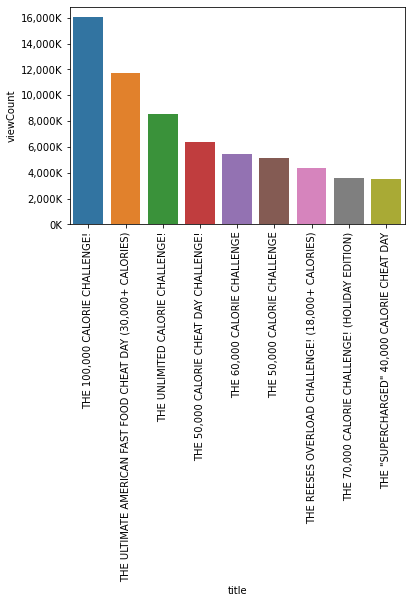

In [66]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

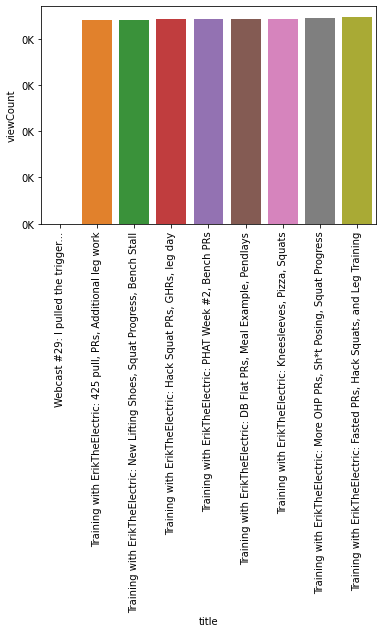

In [67]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

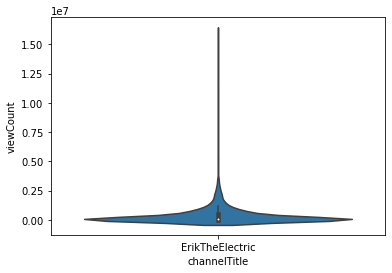

In [68]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

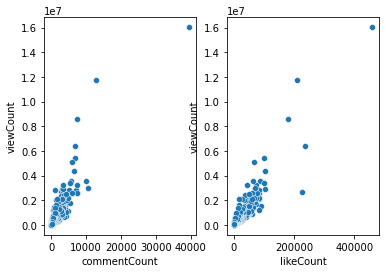

In [69]:

fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

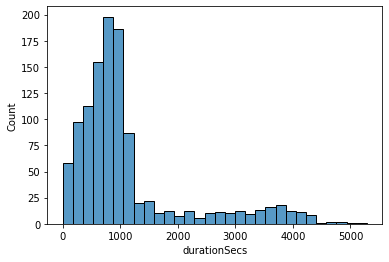

In [70]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

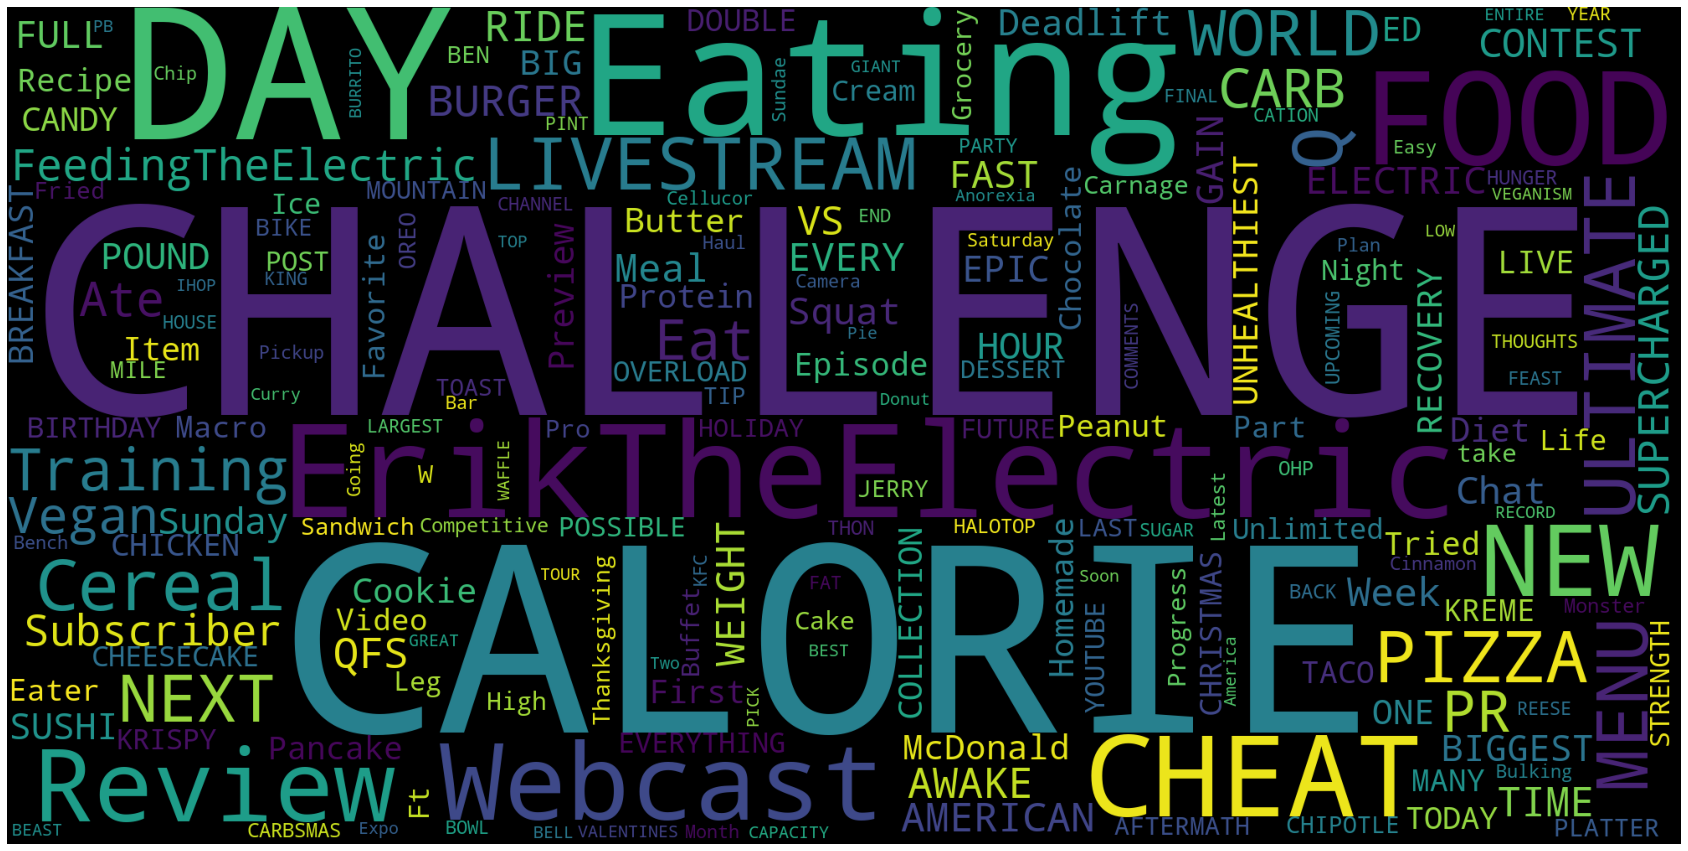

In [76]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)